# Spatial and temporal correlation analysis

## Import libariries

In [14]:
import xarray as xr
import matplotlib.pyplot as plt
from esmtools.stats import autocorr, corr
from scipy.signal import correlate2d
import numpy as np
from matplotlib.animation import FuncAnimation

## Open the data

In [2]:
hindcast_observation = xr.open_zarr('D:\Downloads\s2s-ai-challenge-template-hydroinformatics-group-master-data\data\hindcast-like-observations_2000-2019_biweekly_deterministic.zarr')
tercile_edges = xr.open_dataset('D:\Downloads\s2s-ai-challenge-template-hydroinformatics-group-master-data\data\hindcast-like-observations_2000-2019_biweekly_tercile-edges.nc')
hindcast_ecmwf = xr.open_zarr('D:\Downloads\s2s-ai-challenge-template-hydroinformatics-group-master-data\data\ecmwf_hindcast-input_2000-2019_biweekly_deterministic.zarr')
forecast_ecmwf = xr.open_zarr('D:\Downloads\s2s-ai-challenge-template-hydroinformatics-group-master-data\data\ecmwf_forecast-input_2020_biweekly_deterministic.zarr')

## Auto correlation for the precipitation 

### Cross correlation function

In [3]:
### tpt2m_hindecmwfC = corr(t2m_hindecmwf, tp_hindecmwf, dim = 'forecast_time', lead = -7)
def crosscorr(xinput, ytarget, lags):
    d = []
    lag = []
    for i in range(0, lags):
        x= corr(xinput, ytarget, dim = 'forecast_time', lead = -i)
        l = i
        x['lag'] =([], l)
        d.append(x)
    combined = xr.concat(d, dim = 'lag')
    return combined

#### Correlation for CPC observations

In [4]:
tp_hindobs = hindcast_observation.tp.isel(lead_time = 0).chunk(dict(forecast_time=-1))
t2m_hindobs = hindcast_observation.t2m.isel(lead_time = 0).chunk(dict(forecast_time=-1))

In [5]:
tptp_obsAC = crosscorr(tp_hindobs, tp_hindobs, 5)

Text(0.5, 0, 'lags')

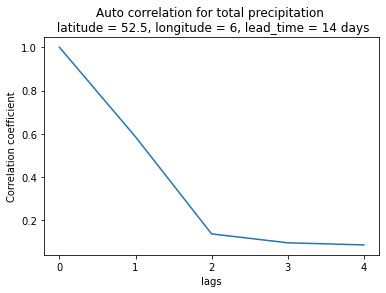

In [6]:
tptp_obsAC.sel(latitude = 52.5, longitude = 6).plot()
plt.xticks([0,1, 2, 3, 4])
plt.title('Auto correlation for total precipitation \n latitude = 52.5, longitude = 6, lead_time = 14 days')
plt.ylabel('Correlation coefficient')
plt.xlabel('lags')

C:\Users\mel010\Anaconda3\lib\site-packages\xskillscore\core\np_deterministic.py:309: RuntimeWarning: invalid value encountered in true_divide
  r = r_num / r_den


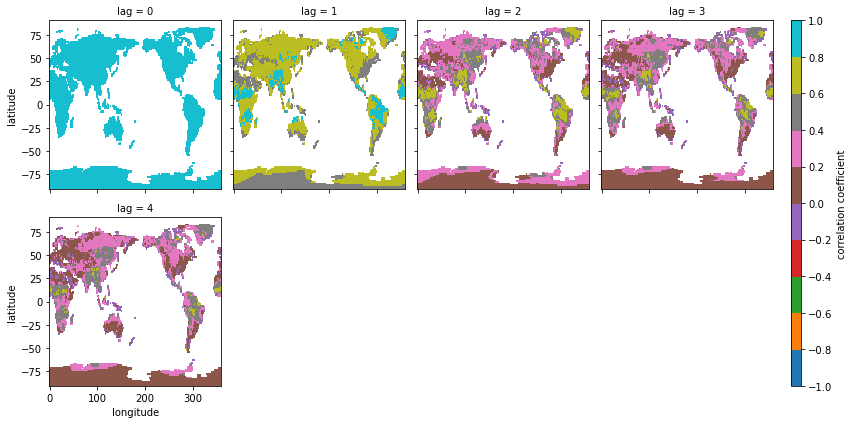

In [7]:
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharex = True)

# ticks = (-1.0, -0.7, -0.4, 0, 0.4, 0.7, 1)
ticks = (-1.0, -0.8, -0.6, -0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1)

# , "boundaries": ticks

tptp_obsAC.plot(col="lag", col_wrap=4, cmap = ('tab10'), cbar_kwargs={"label": "correlation coefficient",
                                                                         "pad": 0.02, "shrink": 1, "aspect": 35, "ticks": ticks,
                                                                     "spacing": 'proportional', "boundaries": ticks})

In [8]:
tp_hindobs = hindcast_observation.tp.isel(lead_time = 0).sel(forecast_time = slice ('2000-01-01', '2011-12-30')).chunk(dict(forecast_time=-1))
t2m_hindobs = hindcast_observation.t2m.isel(lead_time = 0).sel(forecast_time = slice ('2000-01-01', '2011-12-30')).chunk(dict(forecast_time=-1))

In [9]:
t2m_hindobsInt = t2m_hindobs.interpolate_na(dim = 'forecast_time')

In [10]:
tpt2m_hindobsC = crosscorr(t2m_hindobsInt, tp_hindobs, 5)

Text(0.5, 0, 'lags')

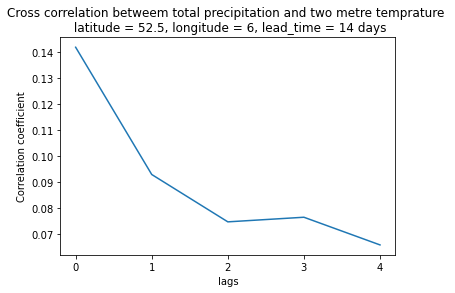

In [11]:
tpt2m_hindobsC.sel(longitude = 6, latitude = 52.5).plot()
plt.xticks([0,1, 2, 3, 4])
plt.title('Cross correlation betweem total precipitation and two metre temprature \n latitude = 52.5, longitude = 6, lead_time = 14 days')
plt.ylabel('Correlation coefficient')
plt.xlabel('lags')

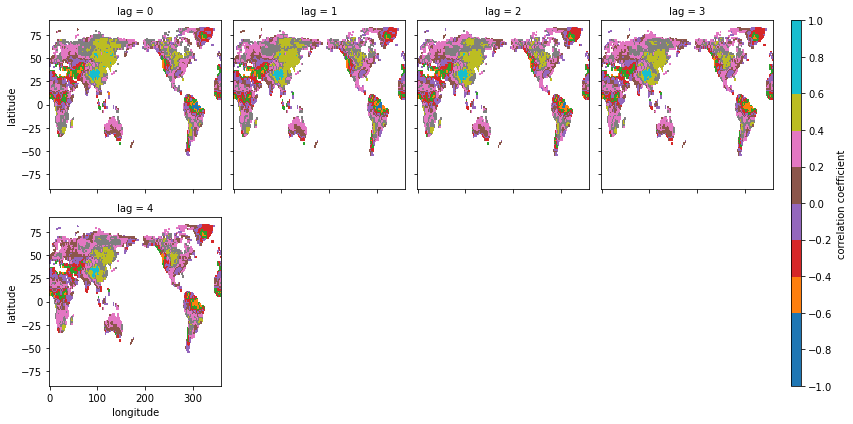

In [12]:
# ticks = (-1.0, -0.7, -0.4, 0, 0.4, 0.7, 1)
# ticks = (-1.0, -0.7, -0.5, -0.25, 0, 0.25, 0.5, 0.7, 1)
ticks = (-1.0, -0.8, -0.6, -0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1)
# , "boundaries": ticks
tpt2m_hindobsC.plot(col="lag", col_wrap=4, cmap = ('tab10'), cbar_kwargs={"label": "correlation coefficient",
                                                                         "pad": 0.02, "shrink": 1, "aspect": 35, "ticks": ticks,
                                                                     "spacing": 'proportional', "boundaries": ticks})

### Mask based on the correlation

In [13]:
lag0 = tpt2m_hindobsC.isel(lag = 0)

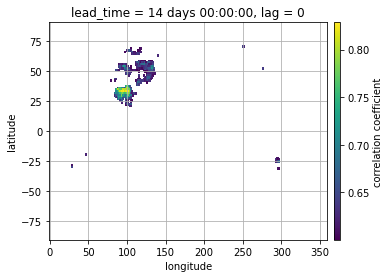

In [14]:
lag0.where(lag0 >= 0.6).plot(cbar_kwargs={"label": "correlation coefficient",
                                                                         "pad": 0.02, "shrink": 1, "aspect": 35,
                                                                     "spacing": 'proportional'})
plt.grid()

In [15]:
lag0.where(lag0 >= 0.6).sel(longitude = 100, latitude = 36, method = 'nearest').values

array(0.80822486, dtype=float32)

Text(0.5, 1.0, 'longitude = 100.5, latitude = 36.0')

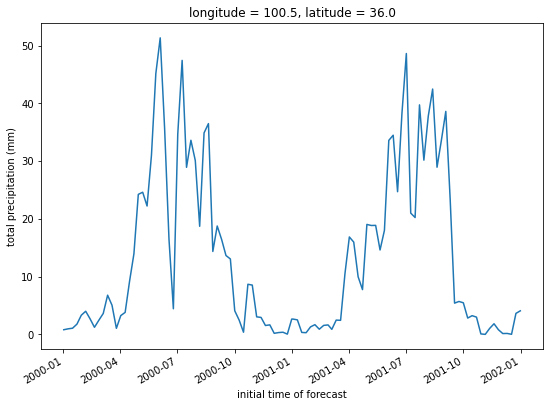

In [16]:
tp_mask1 = hindcast_observation.tp.isel(lead_time = 0).sel(forecast_time = slice('2000-01-01','2002-01-01')).sel(longitude = 100, latitude = 36, method = 'nearest')
tp_mask1.plot(size = 6)
plt.ylabel('total precipitation (mm)')
plt.title('longitude = {}, latitude = {}'.format(tp_mask1.longitude.values, tp_mask1.latitude.values))

Text(0.5, 1.0, 'longitude = 100.5, latitude = 36.0')

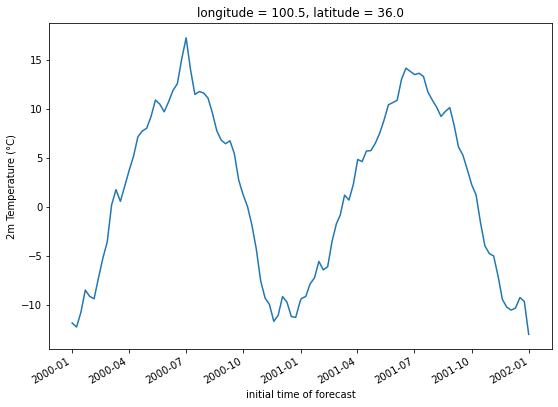

In [17]:
t2m_degreecel =  hindcast_observation.t2m - 273.15
t2m_mask1 = t2m_degreecel.isel(lead_time = 0).sel(forecast_time = slice('2000-01-01','2002-01-01')).sel(longitude = 100, latitude = 36, method = 'nearest')
t2m_mask1.plot(size = 6)
plt.ylabel('2m Temperature (°C)')
plt.title('longitude = {}, latitude = {}'.format(t2m_mask1.longitude.values, t2m_mask1.latitude.values))

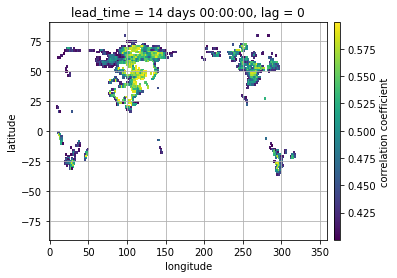

In [18]:
lag0.where(lag0 < 0.6).where(lag0 > 0.4).plot(cbar_kwargs={"label": "correlation coefficient",
                                                                         "pad": 0.02, "shrink": 1, "aspect": 35,
                                                                     "spacing": 'proportional'})
plt.grid()

In [19]:
lag0.where(lag0 < 0.6).where(lag0 > 0.4).sel(longitude = 270, latitude = 50, method = 'nearest').values

array(0.5100306, dtype=float32)

Text(0.5, 1.0, 'longitude = 270.0, latitude = 49.5')

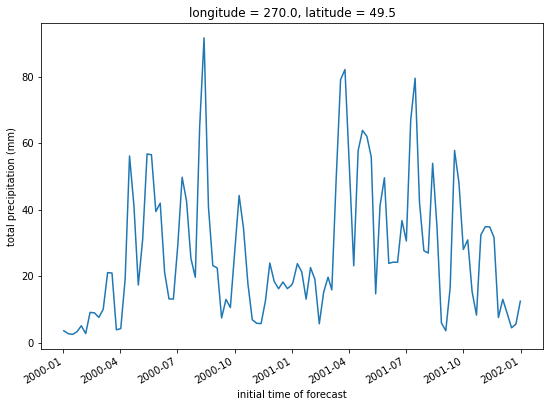

In [20]:
tp_mask2 = hindcast_observation.tp.isel(lead_time = 0).sel(forecast_time = slice('2000-01-01','2002-01-01')).sel(longitude = 270, latitude = 50, method = 'nearest')
tp_mask2.plot(size = 6)
plt.ylabel('total precipitation (mm)')
plt.title('longitude = {}, latitude = {}'.format(tp_mask2.longitude.values, tp_mask2.latitude.values))

Text(0.5, 1.0, 'longitude = 270.0, latitude = 49.5')

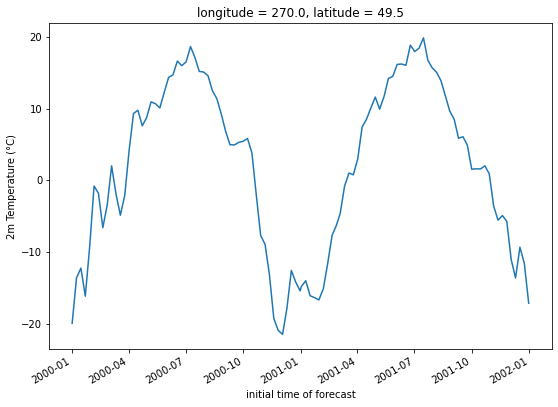

In [21]:
t2m_degreecel =  hindcast_observation.t2m - 273.15
t2m_mask2 = t2m_degreecel.isel(lead_time = 0).sel(forecast_time = slice('2000-01-01','2002-01-01')).sel(longitude = 270, latitude = 50, method = 'nearest')
t2m_mask2.plot(size = 6)
plt.ylabel('2m Temperature (°C)')
plt.title('longitude = {}, latitude = {}'.format(t2m_mask2.longitude.values, t2m_mask2.latitude.values))

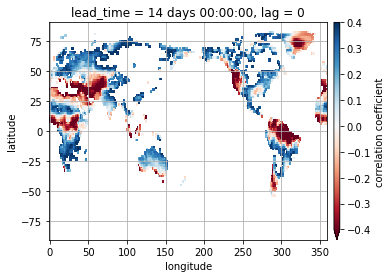

In [22]:
lag0.where(lag0 <= 0.4).plot(vmax = 0.4,cmap = 'RdBu', cbar_kwargs={"label": "correlation coefficient",
                                                                         "pad": 0.02, "shrink": 1, "aspect": 35,
                                                                     "spacing": 'proportional'})
plt.grid()

In [23]:
lag0.where(lag0 <= 0.4).sel(longitude = 1.5, latitude = 42, method = 'nearest').values

array(-0.05224661, dtype=float32)

Text(0.5, 1.0, 'longitude = 1.5, latitude = 42.0')

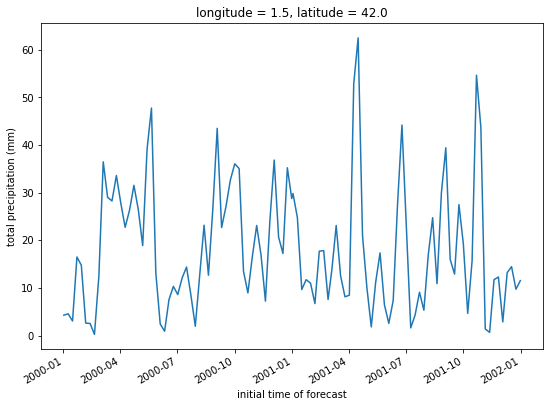

In [24]:
tp_mask3 = hindcast_observation.tp.isel(lead_time = 0).sel(forecast_time = slice('2000-01-01','2002-01-01')).sel(longitude = 1.5, latitude = 42, method = 'nearest')
tp_mask3.plot(size = 6)
plt.ylabel('total precipitation (mm)')
plt.title('longitude = {}, latitude = {}'.format(tp_mask3.longitude.values, tp_mask3.latitude.values))

Text(0.5, 1.0, 'longitude = 1.5, latitude = 42.0')

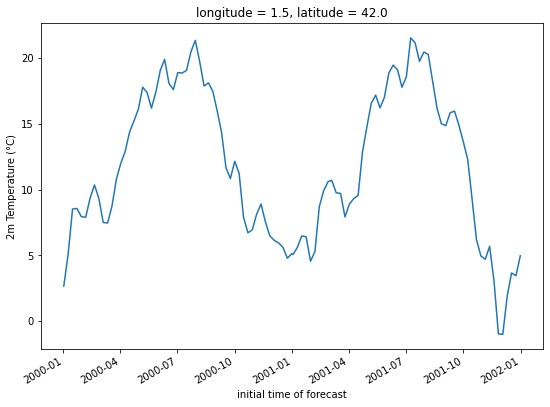

In [25]:
t2m_degreecel =  hindcast_observation.t2m - 273.15
t2m_mask3 = t2m_degreecel.isel(lead_time = 0).sel(forecast_time = slice('2000-01-01','2002-01-01')).sel(longitude = 1.5, latitude = 42, method = 'nearest')
t2m_mask3.plot(size = 6)
plt.ylabel('2m Temperature (°C)')
plt.title('longitude = {}, latitude = {}'.format(t2m_mask3.longitude.values, t2m_mask3.latitude.values))

## Spatial continuity (semivariogram)

### Using geostatspy library

In [3]:
import geostatspy.GSLIB as GSLIB   
import geostatspy.geostats as geostats   

Convert the xarray to dataframe and use reset_index to ensure that the latitude and longitude are in the same line

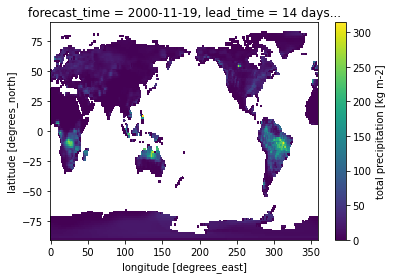

In [4]:
df_hindobs = hindcast_observation.isel(forecast_time = 46, lead_time = 0)
df_hindobs.tp.plot()

In [37]:
# tp_hindobs = hindcast_observation.isel(forecast_time = 0, lead_time = 0)
tp_hindobs = forecast_ecmwf.isel(forecast_time = 20, lead_time = 0).isel(realization = 0)
dftp_hindobs = tp_hindobs.tp.to_dataframe()
dftp_hindobsRI = dftp_hindobs.reset_index()
dftp_hindobsRI

,latitude,longitude,forecast_time,lead_time,realization,valid_time,tp
0,90.0,0.0,2020-05-21,14 days,0,2020-06-04,13.158081
1,90.0,1.5,2020-05-21,14 days,0,2020-06-04,13.158081
2,90.0,3.0,2020-05-21,14 days,0,2020-06-04,13.158081
3,90.0,4.5,2020-05-21,14 days,0,2020-06-04,13.158081
4,90.0,6.0,2020-05-21,14 days,0,2020-06-04,13.158081
...,...,...,...,...,...,...,...
29035,-90.0,352.5,2020-05-21,14 days,0,2020-06-04,2.395874
29036,-90.0,354.0,2020-05-21,14 days,0,2020-06-04,2.395874
29037,-90.0,355.5,2020-05-21,14 days,0,2020-06-04,2.395874
29038,-90.0,357.0,2020-05-21,14 days,0,2020-06-04,2.395874


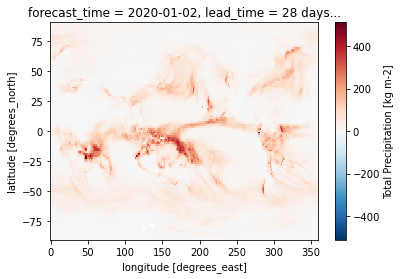

In [30]:
tp_hindobs.tp.plot()

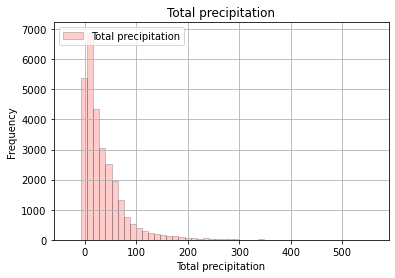

In [38]:
plt.hist(dftp_hindobsRI['tp'], facecolor='red',bins= 50,alpha=0.2,edgecolor='black',label='Total precipitation')
# plt.xlim([0.05,0.25]); plt.ylim([0,35.0])
plt.xlabel('Total precipitation'); plt.ylabel('Frequency'); plt.title('Total precipitation')
plt.legend(loc='upper left')
plt.grid(True)

In [39]:
dftp_hindobsRI['N_tp'], tvtp, tnstp = geostats.nscore(dftp_hindobsRI,"tp")

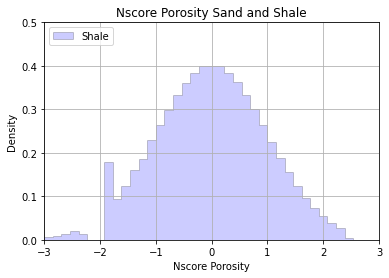

In [40]:
plt.hist(dftp_hindobsRI['N_tp'], facecolor='blue',bins=np.linspace(-3.0,3.0,40),histtype="stepfilled",alpha=0.2,density=True,cumulative=False,edgecolor='black',label='Shale')
plt.xlim([-3.0,3.0]); plt.ylim([0,0.50])
plt.xlabel('Nscore Porosity'); plt.ylabel('Density'); plt.title('Nscore Porosity Sand and Shale')
plt.legend(loc='upper left')
plt.grid(True)

In [41]:
dftp_hindobsRI.describe()

,latitude,longitude,lead_time,realization,tp,N_tp
count,29040.00000,29040.000000,29040,29040.0,28814.000000,28813.000000
mean,0.00000,179.250000,14 days 00:00:00,0.0,35.656796,-0.016064
std,52.39365,103.923936,0 days 00:00:00,0.0,44.515289,0.963150
min,-90.00000,0.000000,14 days 00:00:00,0.0,-31.298096,-3.955668
25%,-45.00000,89.625000,14 days 00:00:00,0.0,7.377686,-0.678559
50%,0.00000,179.250000,14 days 00:00:00,0.0,20.992188,-0.009538
75%,45.00000,268.875000,14 days 00:00:00,0.0,48.629913,0.656127
max,90.00000,358.500000,14 days 00:00:00,0.0,560.323669,2.416558


In [62]:
geostats.gamv

<function geostatspy.geostats.gamv(df, xcol, ycol, vcol, tmin, tmax, xlag, xltol, nlag, azm, atol, bandwh, isill)>

In [42]:
tmin = -9999.; tmax = 9999.; 
lag_dist = 1.5; lag_tol = 1.5; nlag = 100; bandh = 9999.9; azi = 0; atol = 90.0; isill = 1

lag, tp_gamma, tp_npair = geostats.gamv(dftp_hindobsRI,"longitude","latitude","N_tp",tmin,tmax,lag_dist,lag_tol,nlag,azi,atol,bandh,isill)

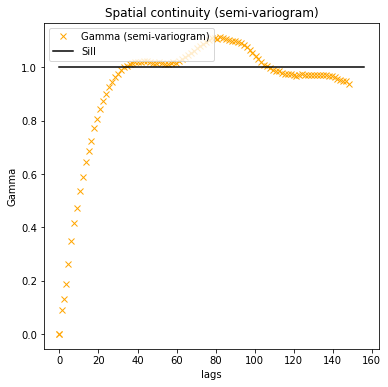

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharex = True)
axes.plot(lag,tp_gamma,'x',color = 'orange',label = 'Gamma (semi-variogram)')
x = axes.get_xlim()
axes.plot([0,x[1]],[1.0,1.0], color = 'black', label = 'Sill')
axes.set(xlabel = 'lags', ylabel = 'Gamma', title= 'Spatial continuity (semi-variogram)')
axes.legend(loc = 'upper left')